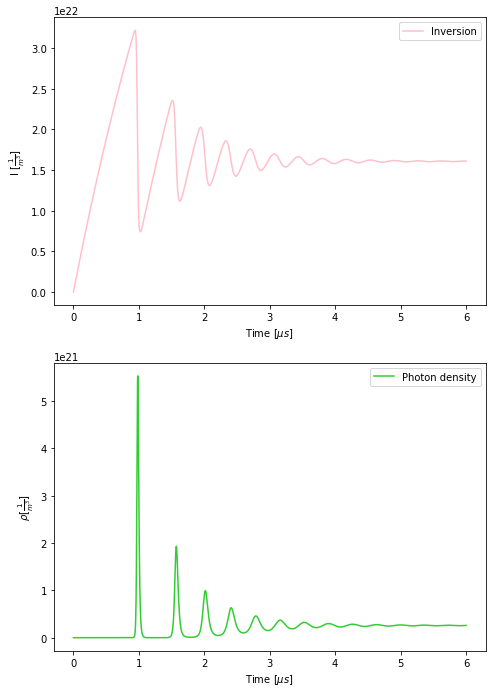

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from astropy import constants as const

#Ved Q-switching ændre man på sin losses efter et stykke tid
#Should start after the first peak

c = const.c.value
S = 10**(-15)
tconv = 10**6
t_Q = 1e-6

laser = 'Nd:YAG'
#starname     = 'KWHya'

re = 2
#re = 4

Qsw = False
#Qsw = True

if Qsw == True:
    qsw = True
elif Qsw == False:
    qsw = False

if (laser == 'Nd:YAG' and re == 2):
    #Active medium
    Ntot = 10**23         
    sigma = 2.8*10**(-23)
    A = 1/(230*10**(-6))
    
    #Resonator
    losses = 0.9
    L = 1 #Length
    tau = (2*L)/(c*(losses))
    
    #Laser parameters
    Ith = 1/(c*sigma*tau)
    Wth = (Ith*A)/(Ntot-Ith)
    Wp = 500*Wth
    
    #Solve_ivp solves the problem:
    y0 = [0, 1]
    
    tf = 6*10**(-6)
  
    #Colour parameters
    colour0 = 'pink'
    colour1 = 'limegreen'

if (laser == 'Nd:YAG' and re == 4):
    global N1B, N2B, N3B
    
    #Properties
    OPL = 0.3277 #m (Optical path length)
    n = 1.82 # (Index of YAG)
    Am = 4.2429*10**(-3)*10**(-3) #m^2 (Mode area)
    Vm = 2.5457*10**(-2)*10**(-6) #m^3 (Mode volume)
    N0 = 3.513*10**(18) # (Population of ground state)
    sigma21 = 6.5*10**(-19)*10**(-3) #m^2 (Stimulated Emission Cross Section Area)
    CWPUMP = 2
    hv808 = 2.4601*10**(-19)
    P = CWPUMP/hv808
    
    #Resonator
    losses = 0.9
    L = 1 #Length
    taucav = (2*L)/(c*(losses))
    
    #Initial population
    N1B = 1.39767*10**(14)
    N2B = 3.556*10**(-6) #0
    N3B = 5.661*10**(-8) #0
    
    #Solve_ivp solves the problem
    y0 = [N1B, N2B, N3B, 0]
    
    tf = 4*10**(-5)
    
    #Time constants
    tau10 = 11*10**(-9)
    tau20 = 395*10**(-6)
    tau21 = 550*10**(-6)
    tau30 = 50*10**(-6)
    tau32 = 450*10**(-12)
    tau2 = (tau20**(-1)+tau21**(-1))**(-1)
    tau3 = (tau30**(-1)+tau32**(-1))**(-1)
    tauRT = (2*OPL)/c
    
    #Colour parameters
    colour0 = 'black'
    colour1 = 'gold'
    colour2 = 'orange'
    colour3 = 'limegreen'


def RE2(t, y):
    global losses_Q, tau, Qsw
    
    #N3 = N1 = 0
    #N3 has an infiniteal small lifetime
    
    I = y[0]
    p = y[1]
    
    if t > t_Q and Qsw == True:
        losses_Q = 0.2
        tau = (2*L)/(c*(losses_Q))
        Qsw = False
    
    dIdt = Wp*(Ntot-I) - sigma*c*p*I-A*I #sigma*c*p*I (gain) [I] = m^-3
    dpdt = p*(sigma*c*I-1/tau)+S*A*I #S*A*I (spon)
    
    return dIdt, dpdt


def RE4(t, y):
    global losses_Q, taucav, Qsw
    
    #dN0/dt = 0
    
    N1 = y[0]
    N2 = y[1]
    N3 = y[2]
    I21 = y[3]
    
    if t > 1.6e-5 and Qsw == True:
        losses_Q = 0.02
        taucav = (2*L)/(c*(losses_Q))
        Qsw = False
    
    dN1dt = I21*sigma21*(N2-N1)+N2/tau21-(N1-N1B)/tau10
    dN2dt = -I21*sigma21*(N2-N1)-(N2-N2B)*(1/tau20+1/tau21)+N3/tau32
    dN3dt = P-(N3-N3B)*(1/tau30+1/tau32)
    dI21dt = I21*sigma21*(N2-N1)*c/(n*Vm)-I21/taucav+S
    
    return dN1dt, dN2dt, dN3dt, dI21dt

#Time settting output:
time_step = 0.1
time_interval = np.linspace(0,tf,10000)
t = time_interval

time_init = 0
time_end = tf

if (re == 2):
    RE = RE2
elif (re == 4):
    RE = RE4

mysol = solve_ivp(RE, (time_init, time_end), y0=y0, t_eval=time_interval)
 
#Output is collected:
if (re == 2 and qsw == False):
    fig = plt.figure()
    fig.subplots_adjust(top = 0.8)

    ax1 = fig.add_axes([0.15,1,1,1])
    ax1.set_xlabel('Time $[\\mu s]$')
    ax1.set_ylabel('I $[\\frac{1}{m^3}]$')
    line1 = ax1.plot(mysol.t*tconv,mysol.y[0],label='Inversion', color = colour0)

    ax2 = fig.add_axes([0.15,-0.2,1,1])
    ax2.set_xlabel('Time $[\\mu s]$')
    ax2.set_ylabel('$\\rho [\\frac{1}{m^3}]$')
    line2 = ax2.plot(mysol.t*tconv,mysol.y[1],label='Photon density', color = colour1)

    ax1.legend()
    ax2.legend()
    plt.show()

if (re == 2 and qsw == True):
    fig = plt.figure()
    fig.subplots_adjust(top = 0.8)

    ax1 = fig.add_axes([0.15,1,1,1])
    ax1.set_xlabel('Time $[\\mu s]$')
    ax1.set_ylabel('I $[\\frac{1}{m^3}]$')
    line1 = ax1.plot(mysol.t*tconv,mysol.y[0],label='Inversion', color = colour0)

    ax2 = fig.add_axes([0.15,-0.2,1,1])
    ax2.set_xlabel('Time $[\\mu s]$')
    ax2.set_ylabel('$\\rho [\\frac{1}{m^3}]$')
    line2 = ax2.plot(mysol.t*tconv,mysol.y[1],label='Photon density', color = colour1)
    
    ax3 = fig.add_axes([0.15,-1.4,1,1])
    ax3.set_xlabel('Time $[\\mu s]$')
    ax3.set_ylabel('L')
    x = [0, t_Q*tconv, mysol.t[-1]*tconv]
    y = [losses_Q, losses, losses_Q]
    ax3.set_xlim(0, mysol.t[-1]*tconv)
    line3 = ax3.step(x,y,label='Losses', color = 'black')

    ax1.legend()
    ax2.legend()
    ax3.legend()
    plt.show()    

if (re == 4):
    fig = plt.figure()
    fig.subplots_adjust(top = 0.8)

    ax1 = fig.add_axes([0.15,1,1,1])
    ax1.set_xlabel('Time $[\\mu s]$', fontsize = 15)
    ax1.set_ylabel('N', fontsize = 15)
    line1 = ax1.semilogy(mysol.t*tconv,mysol.y[0],label='Population 1', color = colour0)

    ax2 = fig.add_axes([0.15,-0.2,1,1])
    ax2.set_xlabel('Time $[\\mu s]$', fontsize = 15)
    ax2.set_ylabel('N', fontsize = 15)
    line2 = ax2.semilogy(mysol.t*tconv,mysol.y[1],label='Population 2', color = colour1)
    
    ax3 = fig.add_axes([0.15,-1.4,1,1])
    ax3.set_xlabel('Time $[\\mu s]$', fontsize = 15)
    ax3.set_ylabel('N', fontsize = 15)
    line3 = ax3.semilogy(mysol.t*tconv,mysol.y[2],label='Population 3', color = colour2)

    ax4 = fig.add_axes([0.15,-2.6,1,1])
    ax4.set_xlabel('Time $\\mu s$', fontsize = 15)
    ax4.set_ylabel('$\\rho c ~ [\\frac{1}{m^2s}]$', fontsize = 15)
    line4 = ax4.semilogy(mysol.t*tconv,mysol.y[3],label='Photon flux', color = colour3)

    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    plt.show()